# Group members #

| Name               | Matricula    | Email                                   |
| ------------------ | ------------ | --------------------------------------- |
| Giacomo Bellini    | 1970896      | bellini.1970896@studenti.uniroma1.it    |
| Ludovica Mazza     | 1917778      | mazza.1917778@studenti.uniroma1.it      |
| Matteo Rampolla    | 1762214      | rampolla.1762214@studenti.uniroma1.it   |
| Daniele Solombrino | 1743111      | solombrino.1743111@studenti.uniroma1.it |

# Reports #

**Reports** for hyperparameter fine-tuning and custom models are in the **"reports" folder**

## Table of contents:
* Initial Setup
* Data Loading and Preprocessing
    * Data Variables
* Model Instantiation
* Optimizer and Scheduler
* Train and Evaluation Loop
    * Save the model and plot the losses (**1 Point**)
* Test Loop  
* Human Pose Visualization (**2 Points**)
* Report and Parameter Fine-Tuning Analysis  (**4 Points**)
* Calculating MPJPE for a Specific Frame  (**2 Points**)
* Iterative Mechanism (**3 Points**)
* YOUR custom model (**3 Points**)
    * Performance BONUS (**Up to 2 Points**)



## Initial Setup
Run the following two cellls to sync with Google Drive only if you run from Google Colab.

*Note: we recommend using Google Colab for this specific homework, since the training phase will require a GPU*

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
%cd /content/drive/MyDrive/AML/Practice

[Errno 2] No such file or directory: '/content/drive/MyDrive/AML/Practice'
/home/dansolombrino/PARA/Projects/AML Assignment/AML_Homework/Practice


Welcome to this guide on training, testing, and fine-tuning a deep learning model. Deep learning is at the forefront of artificial intelligence, with applications spanning image recognition, natural language processing, and more.

Throughout this assignment, you'll:

1. **Prepare Data:** Preprocess and load the data.

2. **Use Neural Networks:** Instantiate a neural network architecture.

3. **Train Models:** Utilize optimization, loss functions, and backpropagation.

4. **Evaluate Performance:** Assess model performance, prevent overfitting, and underfitting.

5. **Fine-Tune Models:** Explore hyperparameter tuning.

In [3]:
from utils import h36motion3d as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.autograd
import torch
import numpy as np
import pandas as pd
from utils.loss_funcs import *
from utils.data_utils import define_actions
from utils.h36_3d_viz import visualize
import time

import torch.nn.functional as F

from utils.loss_funcs import mpjpe_error

#for plots
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm

In [4]:
# Use GPU if available, otherwise stick with cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device,  '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: NVIDIA GeForce RTX 3090


## Data Loading and Preprocessing

For this homework, you will use [Human3.6M](https://vision.imar.ro/human3.6m/pami-h36m.pdf), which is a large-scale dataset of 3.6 million accurate 3D human poses acquired by recording the performance of five female and six male subjects under four different viewpoints. The dataset includes:
- Synchronized image.
- Human motion capture.
- Time of flight (depth) data.
- Accurate 3D body scans of all the subject actors involved.

The dataset aims to provide diverse motions and poses encountered in typical human activities, with additional data to train realistic human sensing systems.

![picture](https://drive.google.com/uc?export=view&id=1nyD1_F3r1ctexKFGDmhy2Q9SX_2Z_bpS)

For this assignment, we will leverage the rich **motion data** (See in the figure above) provided by H3.6M to perform a task known as *motion prediction*. Motion prediction involves using historical motion data to forecast future movements. This task is fundamental in human-robot interaction, animation, and sports analytics applications.

### Data Variables

Each created sequence has the shape (35, 17, 3), where:
- Number of observed sequences and number of sequences to predict: $N_{obs}+N_{pred} = 10 + 25 = 35$;
- Number of body joints to consider: $J=22$;
- Spatial coordinates: $(x,y,z) = 3$.


The original data provides high-resolution progressive scan videos at 50 Hz. However, the dataset has been downsampled to 25 Hz for research purposes. This means that 25 frames of motion data are provided per second.

*Note: the figure above shows 18 joints, however the dataset contains 32. For this specific case we will consider 22 joints, ignoring some of the finer ones (e.g. foot tip, hand tip, etc)*


In [5]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22


#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

Load Dataset

*Note: It will take you ~ 5 minutes*

In [6]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


/home/dansolombrino/PARA/Projects/AML Assignment/AML_Homework/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


Following we create a torch dataloader that create the batches for each epoch.

In [7]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 180077
>>> Validation dataset length: 28110


## Model instantiation


Each sequence comprises an **observed** part to train the Encoder and a part that attempts to predict the **future** sequence, the Decoder.

Generally, the standard setup plans to use the first 10 sequences of poses ($N_{obs}=10$) for the observation and the following 25 ($N_{pred} = 25$) for the prediction.


We create an instance of a custom Spatio-Temporal transformer with the chosen configuration.

(*Note: explore the model in ./models/sttr/sttformer.py*)

Then we allocate it to the GPU for forward and backward accelerated computation.

In [8]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26859


## Optimizer and Scheduler

As we embark on training deep learning models for motion prediction using the H3.6M dataset, it's essential to recognize several key parameters and components that significantly impact the training phase:

- **Learning Rate:** This parameter determines the convergence speed during optimization.

- **Batch Size:** It influences model generalization and training efficiency.

- **Number of Epochs:** The number of training iterations affects model learning.

- **Loss Function:** The choice of loss function directly affects learning and final performance.

- **Optimizer:** The optimization algorithm used (e.g., Adam, SGD) impacts gradient descent during training.

- **Milestones and Gamma:** These parameters control learning rate schedules, allowing for adaptive adjustments during training.

- **Weight Decay:** It regulates the impact of model parameters during optimization.

- **Scheduler:** Scheduler strategies (e.g., StepLR, ReduceLROnPlateau) manage learning rate adaptation during training.

In [9]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [10]:
clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 700

In [11]:
import datetime
import os
import wandb

lim_n_batches_percent = 0.05
step_size = 30

train_id = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
ckpt_dir = f"{model_path}{train_id}"
os.makedirs(ckpt_dir) if not os.path.exists(ckpt_dir) else None


train_config = {
  "batch_size": batch_size,
  "lim_n_batches_percent": lim_n_batches_percent,
  "n_heads": n_heads,
  "model": model,
  "num_trainable_parameters": str(sum(p.numel() for p in model.parameters() if p.requires_grad)),
  "lr": lr,
  "use_scheduler": use_scheduler,
  "milestones": milestones,
  "gamma": gamma,
  "step_size": step_size,
  "weight_decay": weight_decay,
  "optimizer": optimizer,
  "scheduler": scheduler if use_scheduler else None,
  "clip_grad": clip_grad,
  "n_epochs": n_epochs,
  "train_id": train_id
}

## Train and Evaluation Loop

The **loss** and **metric** used during training and evaluation respectively, compare the predicted joint positions to ground truth joint positions for all frames, which is typically referred to as the **Average Mean Per
Joint Position Error (A-MPJPE)** can be seen as an $L_2$. This loss quantifies the dissimilarity between the predicted and ground truth joint positions by measuring the squared Euclidean distance between corresponding joint positions.

\begin{align*}
A-MPJPE &= \frac{1}{N_{pred}} \sum_{i=1}^{N_{pred}} \left(\frac{1}{J} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|^2\right)
\end{align*}

$$where:$$

\begin{align*}
P_{\text{predicted}} &: \text{Set of predicted joint positions estimated by the model.} \\
P_{\text{gt}} &: \text{Corresponding set of ground truth joint positions.} \\
\end{align*}

*Note: If you restart the training for any reason, remember to instantiate the model and the optimizer again. This will avoid continuing the training with the initialized weights of the previous one*


### Save the model and plot the losses (1 Point)

**Objective:** In this exercise, you will practice implementing a code snippet to save your deep learning model's checkpoints and visualize the training and validation loss on the same plot every 5 epochs during model training.

Your task is to implement the following:

- Set up a mechanism to save the model's checkpoints (weights and architecture) during training. These checkpoints should be saved periodically, say, **every 5 epochs**.

- Create a plot displaying the training and validation losses on the same graph. The x-axis should represent the number of epochs, and the y-axis should represent the loss values. The training and validation losses should be plotted as separate lines on the same graph.

- Ensure that the code saves the model's checkpoints in a specified directory, including the model's architecture and weights, and that the loss plot is displayed.

Analyze the loss plot to gain insights into how your model is learning over time and whether there are any signs of overfitting or underfitting.

*Note: see the Pytorch Documentation on how to save your model's checkpoints.*


In [12]:
def train(data_loader,vald_loader, path_to_save_model=None):

  n_train_batches = int(len(data_loader) * lim_n_batches_percent) + 1
  n_val_batches = int(len(vald_loader) * lim_n_batches_percent) + 1

  #TODO controlla errore: metodo non esisteva
  #wandb.init(project="Spatio-Temporal Transformer fine-tuning", config=train_config)

  train_loss = []
  val_loss = []
  val_loss_best = 1000



  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs-1):
      running_loss=0
      n=0
      model.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

          optimizer.zero_grad()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)


          loss=mpjpe_error(sequences_predict,sequences_gt)


          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim


              sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
              sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

              sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
              loss=mpjpe_error(sequences_predict,sequences_gt)

              if cnt % log_step == 0:
                        print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))
              running_loss+=loss*batch_dim
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n

      if use_scheduler:
        scheduler.step()

      # save and plot model every 5 epochs
      '''
      Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
      '''
      if save_and_plot and epoch % 5 == 0:
        torch.save(model.state_dict(), path_to_save_model + model_name + "_epoch_" + str(epoch+1) + ".pt")

        # This is the only part modified by us, just to avoid creating a new plot for every 5 epochs
        # Create a figure and axis for the plot
        # Instead of creating one plot every 5 epochs we are going to update the already existing plot
        fig, ax = plt.subplots()
        lines, = ax.plot([], [], 'b', label='Training Loss')
        lines2, = ax.plot([], [], 'r', label='Validation Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training and Validation Loss')
        ax.legend()

        # Customizing the grid
        plt.grid(True, linestyle='--', linewidth=0.5, color='gray')  # Enable grid with custom style

        plt.tight_layout()

        #draw the training loss
        lines.set_data(range(1, epoch+2), train_loss)

        #draw the validation loss
        lines2.set_data(range(1, epoch+2), val_loss)
        ax.relim()
        ax.autoscale_view()

        # Redraw the figure
        fig.canvas.draw()

        #wandb.log({
        #  "epoch": epoch,
        #  "loss/train": train_loss[-1],
        #  "loss/val": val_loss[-1]
        #})

        # Display the plot when done
        plt.show()


[Epoch: 1, Iteration:     1]  training loss: 559.068
[Epoch: 1, Iteration:   701]  training loss: 109.917
[Epoch: 1, Iteration:     1]  validation loss: 114.634


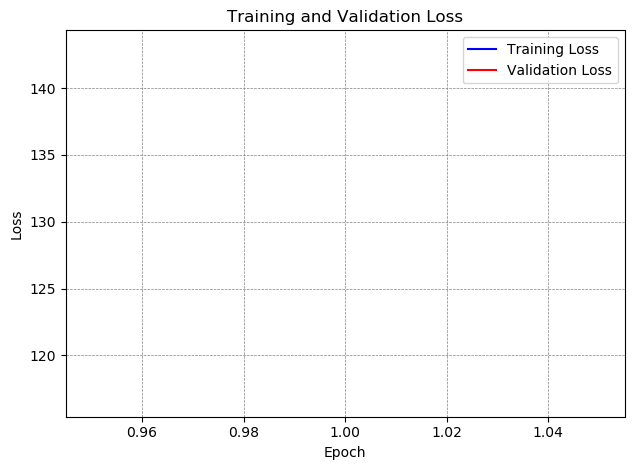

[Epoch: 2, Iteration:     1]  training loss: 117.113
[Epoch: 2, Iteration:   701]  training loss: 104.101
[Epoch: 2, Iteration:     1]  validation loss: 91.542
[Epoch: 3, Iteration:     1]  training loss: 102.920
[Epoch: 3, Iteration:   701]  training loss: 104.027
[Epoch: 3, Iteration:     1]  validation loss: 98.730
[Epoch: 4, Iteration:     1]  training loss: 101.216
[Epoch: 4, Iteration:   701]  training loss: 97.726
[Epoch: 4, Iteration:     1]  validation loss: 97.010
[Epoch: 5, Iteration:     1]  training loss: 96.233
[Epoch: 5, Iteration:   701]  training loss: 94.404
[Epoch: 5, Iteration:     1]  validation loss: 87.505
[Epoch: 6, Iteration:     1]  training loss: 97.341
[Epoch: 6, Iteration:   701]  training loss: 90.278
[Epoch: 6, Iteration:     1]  validation loss: 92.383


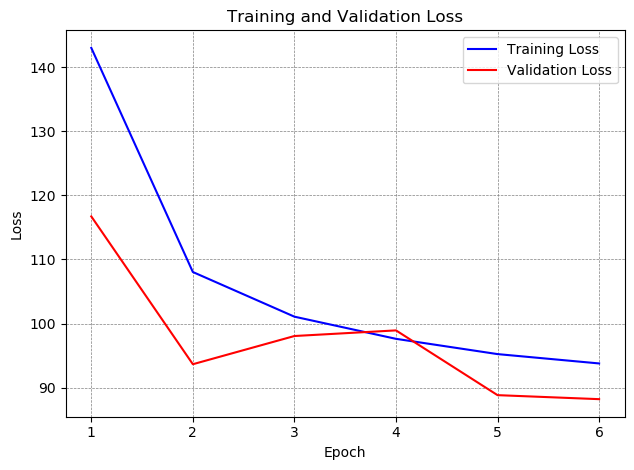

[Epoch: 7, Iteration:     1]  training loss: 92.176
[Epoch: 7, Iteration:   701]  training loss: 91.200
[Epoch: 7, Iteration:     1]  validation loss: 87.615
[Epoch: 8, Iteration:     1]  training loss: 86.953
[Epoch: 8, Iteration:   701]  training loss: 94.600
[Epoch: 8, Iteration:     1]  validation loss: 90.020
[Epoch: 9, Iteration:     1]  training loss: 89.023
[Epoch: 9, Iteration:   701]  training loss: 87.913
[Epoch: 9, Iteration:     1]  validation loss: 84.968
[Epoch: 10, Iteration:     1]  training loss: 94.389
[Epoch: 10, Iteration:   701]  training loss: 84.142
[Epoch: 10, Iteration:     1]  validation loss: 88.927
[Epoch: 11, Iteration:     1]  training loss: 85.534
[Epoch: 11, Iteration:   701]  training loss: 87.179
[Epoch: 11, Iteration:     1]  validation loss: 84.957


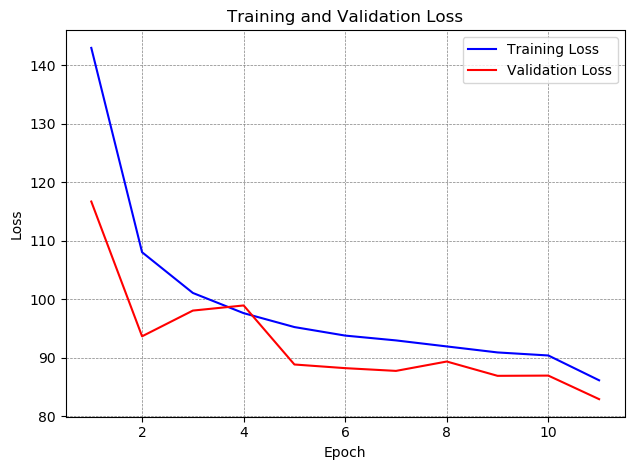

[Epoch: 12, Iteration:     1]  training loss: 89.583
[Epoch: 12, Iteration:   701]  training loss: 83.874
[Epoch: 12, Iteration:     1]  validation loss: 82.497
[Epoch: 13, Iteration:     1]  training loss: 85.572
[Epoch: 13, Iteration:   701]  training loss: 85.790
[Epoch: 13, Iteration:     1]  validation loss: 82.820
[Epoch: 14, Iteration:     1]  training loss: 80.880
[Epoch: 14, Iteration:   701]  training loss: 80.840
[Epoch: 14, Iteration:     1]  validation loss: 82.808
[Epoch: 15, Iteration:     1]  training loss: 85.512
[Epoch: 15, Iteration:   701]  training loss: 89.453
[Epoch: 15, Iteration:     1]  validation loss: 85.189
[Epoch: 16, Iteration:     1]  training loss: 81.904
[Epoch: 16, Iteration:   701]  training loss: 86.419
[Epoch: 16, Iteration:     1]  validation loss: 84.729


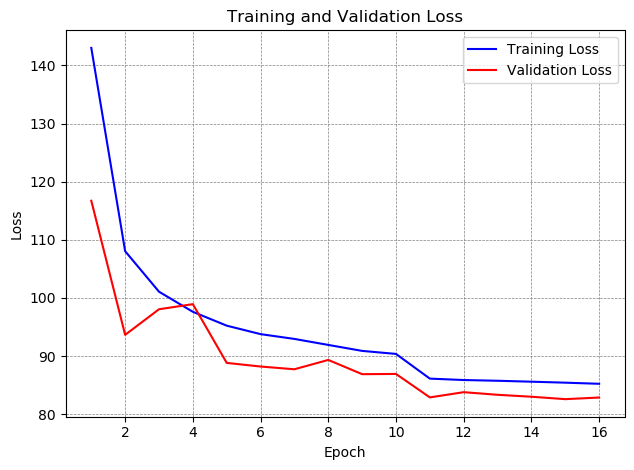

[Epoch: 17, Iteration:     1]  training loss: 90.407
[Epoch: 17, Iteration:   701]  training loss: 82.536
[Epoch: 17, Iteration:     1]  validation loss: 83.877
[Epoch: 18, Iteration:     1]  training loss: 86.172
[Epoch: 18, Iteration:   701]  training loss: 85.070
[Epoch: 18, Iteration:     1]  validation loss: 79.262
[Epoch: 19, Iteration:     1]  training loss: 85.595
[Epoch: 19, Iteration:   701]  training loss: 82.380
[Epoch: 19, Iteration:     1]  validation loss: 82.247
[Epoch: 20, Iteration:     1]  training loss: 87.608
[Epoch: 20, Iteration:   701]  training loss: 82.719
[Epoch: 20, Iteration:     1]  validation loss: 81.642
[Epoch: 21, Iteration:     1]  training loss: 86.408
[Epoch: 21, Iteration:   701]  training loss: 84.825
[Epoch: 21, Iteration:     1]  validation loss: 80.985


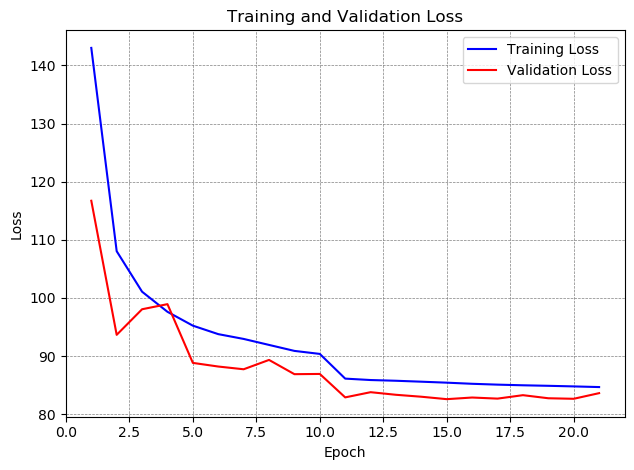

[Epoch: 22, Iteration:     1]  training loss: 86.110
[Epoch: 22, Iteration:   701]  training loss: 85.663
[Epoch: 22, Iteration:     1]  validation loss: 79.261
[Epoch: 23, Iteration:     1]  training loss: 88.854
[Epoch: 23, Iteration:   701]  training loss: 82.085
[Epoch: 23, Iteration:     1]  validation loss: 83.235
[Epoch: 24, Iteration:     1]  training loss: 81.009
[Epoch: 24, Iteration:   701]  training loss: 82.354
[Epoch: 24, Iteration:     1]  validation loss: 78.358
[Epoch: 25, Iteration:     1]  training loss: 83.985
[Epoch: 25, Iteration:   701]  training loss: 82.279
[Epoch: 25, Iteration:     1]  validation loss: 86.141
[Epoch: 26, Iteration:     1]  training loss: 84.595
[Epoch: 26, Iteration:   701]  training loss: 89.179
[Epoch: 26, Iteration:     1]  validation loss: 82.182


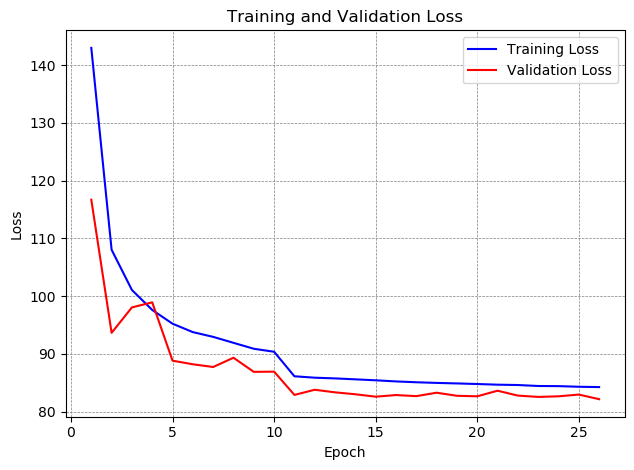

[Epoch: 27, Iteration:     1]  training loss: 84.428
[Epoch: 27, Iteration:   701]  training loss: 85.331
[Epoch: 27, Iteration:     1]  validation loss: 82.688
[Epoch: 28, Iteration:     1]  training loss: 86.543
[Epoch: 28, Iteration:   701]  training loss: 86.045
[Epoch: 28, Iteration:     1]  validation loss: 81.414
[Epoch: 29, Iteration:     1]  training loss: 88.592
[Epoch: 29, Iteration:   701]  training loss: 84.976
[Epoch: 29, Iteration:     1]  validation loss: 82.084
[Epoch: 30, Iteration:     1]  training loss: 84.255
[Epoch: 30, Iteration:   701]  training loss: 85.883
[Epoch: 30, Iteration:     1]  validation loss: 83.005
[Epoch: 31, Iteration:     1]  training loss: 80.836
[Epoch: 31, Iteration:   701]  training loss: 79.699
[Epoch: 31, Iteration:     1]  validation loss: 80.513


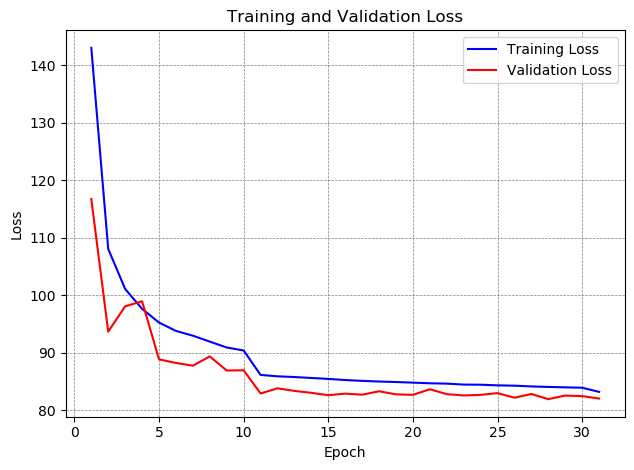

[Epoch: 32, Iteration:     1]  training loss: 84.575
[Epoch: 32, Iteration:   701]  training loss: 81.527
[Epoch: 32, Iteration:     1]  validation loss: 81.229
[Epoch: 33, Iteration:     1]  training loss: 80.224
[Epoch: 33, Iteration:   701]  training loss: 85.052
[Epoch: 33, Iteration:     1]  validation loss: 81.571
[Epoch: 34, Iteration:     1]  training loss: 83.490
[Epoch: 34, Iteration:   701]  training loss: 86.695
[Epoch: 34, Iteration:     1]  validation loss: 83.261
[Epoch: 35, Iteration:     1]  training loss: 76.142
[Epoch: 35, Iteration:   701]  training loss: 79.814
[Epoch: 35, Iteration:     1]  validation loss: 82.364
[Epoch: 36, Iteration:     1]  training loss: 85.452
[Epoch: 36, Iteration:   701]  training loss: 80.358
[Epoch: 36, Iteration:     1]  validation loss: 82.476


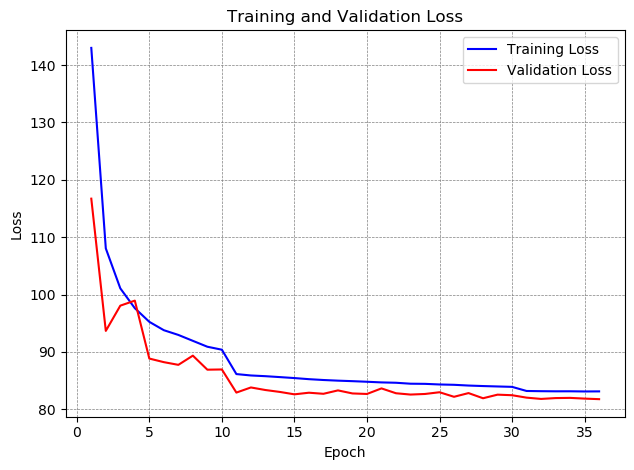

[Epoch: 37, Iteration:     1]  training loss: 80.650
[Epoch: 37, Iteration:   701]  training loss: 79.439
[Epoch: 37, Iteration:     1]  validation loss: 84.071
[Epoch: 38, Iteration:     1]  training loss: 90.455
[Epoch: 38, Iteration:   701]  training loss: 86.008
[Epoch: 38, Iteration:     1]  validation loss: 82.384
[Epoch: 39, Iteration:     1]  training loss: 80.463
[Epoch: 39, Iteration:   701]  training loss: 82.663
[Epoch: 39, Iteration:     1]  validation loss: 82.427
[Epoch: 40, Iteration:     1]  training loss: 82.995
[Epoch: 40, Iteration:   701]  training loss: 81.446
[Epoch: 40, Iteration:     1]  validation loss: 79.600


In [13]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

# launch training
train(data_loader,vald_loader, path_to_save_model=model_path)

## Test Loop

After training and validation, the test loop is the final phase that evaluates the model's performance on an entirely independent dataset known as the test dataset. This dataset is distinct from the training and validation data, ensuring unbiased assessment. The test loop provides a reliable estimate of how well the model will perform in real-world scenarios, confirming that any improvements observed during training and validation are not due to overfitting or chance. It's a crucial step before deploying the model in practical applications.

In [ ]:
def test(ckpt_path=None):


    action_loss_dict = {}
    n_test_batches = int(len(data_loader) * lim_n_batches_percent) + 1

    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,output_n,32,3),sequences_gt.view(-1,output_n,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))

      action_loss_dict[f"loss/test/{action}"] = np.round((running_loss/n).item(),1)

      n_batches+=n


    #WANDB
    action_loss_dict["loss/test"] = np.round((accum_loss/n_batches).item(),1)
    #wandb.log(action_loss_dict)

    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)



*Note: Your results should be better than 95 millimiters on average*

In [ ]:
ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_40.pt' # Change the epoch according to the validation curve
test(ckpt_path)

model loaded


/content/drive/MyDrive/AML/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  61.8
eating :  58.8
smoking :  59.0
discussion :  86.9
directions :  78.2
greeting :  100.8
phoning :  73.8
posing :  116.7
purchases :  99.7
sitting :  86.6
sittingdown :  109.1
takingphoto :  86.6
waiting :  80.9
walkingdog :  111.5
walkingtogether :  60.7
Average: 84.7
Prediction time:  0.015538534025351207


### Comment on the results

The wide range of scores (from 58.8 to 116.7) suggests that some activities are inherently more challenging for the model to predict accurately. Activities like 'posing' and 'sittingdown' have notably high scores, indicating that these activities might have more nuanced or less distinct patterns, making them harder for the model to learn and predict accurately.

The model performs notably well in everyday activities such as 'walking', 'eating', and 'smoking'. While for more complex task the score is a bit higher; for example the score for 'greeting' is 100.8, which is relatively high. This might be due to the diverse ways in which greetings are performed.

In summary, these results paint a picture of a model that is generally effective at recognizing and differentiating between various human activities, with particular strengths in more common and straightforward activities.

## Human Pose Visualization  (**2 Points**)

The qualitative results are as important as the quantitative ones. In this section, you will visualize and compare the predicted poses with the ground truth ones.
For simplicity, you will visualize only the first predicted pose and the ground truth.

Ideally, the same plot should show the predicted pose in red and the ground truth one in green.

*Note: you will find which nodes are connected in the file ./models/skeleton_connection.py*

In [ ]:
'''
Insert your code below
'''
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from utils import h36motion3d as datasets
from utils.loss_funcs import mpjpe_error
from utils.data_utils import define_actions
from matplotlib import gridspec

# Define the function for creating the pose visualization
def create_pose(ax, plots, vals, pred=True, update=False):
    '''
    Creates a 3D pose using the given joint values.

    Parameters:
    ax (matplotlib axis): The 3D axis for plotting.
    plots (list): List of plot objects.
    vals (numpy array): Array of joint coordinates.
    pred (bool): Flag to determine if the pose is a prediction.
    update (bool): Flag to update the plot if it already exists.
    '''

    # Define connections between joints and their properties
    connect = [(1, 2), (2, 3), (3, 4), (4, 5), (6, 7), (7, 8), (8, 9), (9, 10),
               (0, 1), (0, 6), (6, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22),
               (1, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (24, 25),
               (24, 17), (24, 14), (14, 15)]

    # Specify whether joints are on the left or right side
    LR = [False, True, True, True, True, True, False, False, False, False, False, True, True, True, True, True,
          True, False, False, False, False, False, False, False, True, False, True, True, True, True, True, True]

    # Start and endpoints of our representation
    I = np.array([touple[0] for touple in connect])
    J = np.array([touple[1] for touple in connect])

    #green = prediction
    if pred:
        lcolor = "green"
        rcolor = "green"

    #red = gt
    else:
        lcolor = "red"
        rcolor = "red"

    for i in np.arange(len(I)):
        x = np.array([vals[I[i], 0], vals[J[i], 0]])
        z = np.array([vals[I[i], 1], vals[J[i], 1]])
        y = np.array([vals[I[i], 2], vals[J[i], 2]])

        if not update:
            if i == 0:
                plots.append(ax.plot(x, y, z, lw=2, linestyle='--', c=lcolor if LR[i] else rcolor, label=['Input Frames' if not pred else 'Predicted Frames']))
            else:
                plots.append(ax.plot(x, y, z, lw=2, linestyle='--', c=lcolor if LR[i] else rcolor))
        elif update:
            plots[i][0].set_xdata(x)
            plots[i][0].set_ydata(y)
            plots[i][0].set_3d_properties(z)
            plots[i][0].set_color(lcolor if LR[i] else rcolor)

    return plots

# Define the update function for the animation
def update(num, data_gt, data_pred, plots_gt, plots_pred, fig, ax):
    '''
    Update function for the animation. Updates the plot with new pose data.

    Parameters:
    num (int): The current frame number in the animation.
    data_gt (numpy array): Ground truth pose data.
    data_pred (numpy array): Predicted pose data.
    plots_gt (list): List of plot objects for ground truth.
    plots_pred (list): List of plot objects for prediction.
    fig (matplotlib figure): The figure object for plotting.
    ax (matplotlib axis): The 3D axis for plotting.
    '''

    gt_vals = data_gt[num]
    pred_vals = data_pred[num]

    plots_gt = create_pose(ax, plots_gt, gt_vals, pred=False, update=True)
    plots_pred = create_pose(ax, plots_pred, pred_vals, pred=True, update=True)

    r = 0.75
    xroot, zroot, yroot = pred_vals[0, 0], pred_vals[0, 1], pred_vals[0, 2]
    ax.set_xlim3d([-r + xroot, r + xroot])
    ax.set_ylim3d([-r + yroot, r + yroot])
    ax.set_zlim3d([-r + zroot, r + zroot])

    return plots_gt, plots_pred

# Define the visualization function
def visualize(input_n, output_n, visualize_from, path, modello, device, n_viz, skip_rate, actions):

    '''
    Main function to visualize the poses.

    Parameters:
    input_n (int): Number of input frames.
    output_n (int): Number of output frames to predict.
    visualize_from (str): The dataset split to visualize ('train', 'validation', 'test').
    path (str): Path to the dataset.
    modello (torch model): The trained PyTorch model.
    device (torch device): The device to run the model on (e.g., 'cuda').
    n_viz (int): Number of sequences to visualize.
    skip_rate (int): The rate at which to skip frames in the dataset.
    actions (list): List of actions to visualize.
    '''

    actions = define_actions(actions)

    modello.load_state_dict(torch.load(ckpt_path))

    # Create a directory 'GIFs' if it doesn't exist
    gif_dir = 'GIFs'
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)

    for action in actions:
        if visualize_from == 'train':
            loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=0, actions=[action])
        elif visualize_from == 'validation':
            loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=1, actions=[action])
        elif visualize_from == 'test':
            loader = datasets.Datasets(path, input_n, output_n, skip_rate, split=2, actions=[action])

        dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68, 75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
        joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
        index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
        joint_equal = np.array([13, 19, 22, 13, 27, 30])
        index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))

        loader = DataLoader(loader, batch_size=1, shuffle=True, num_workers=0)

        # Iterate through the batches of data in the loader
        for cnt, batch in enumerate(loader):
            batch = batch.to(device)

            all_joints_seq = batch.clone()[:, input_n:input_n + output_n, :]

            sequences_train = batch[:, 0:input_n, dim_used].view(-1, input_n, len(dim_used)//3, 3).permute(0, 3, 1, 2)
            sequences_gt = batch[:, input_n:input_n + output_n, :]

            # shape is batch,n_frames,n_joints * 3(xyz)
            sequences_predict = modello(sequences_train).contiguous().view(-1, output_n, len(dim_used))

            all_joints_seq[:, :, dim_used] = sequences_predict

            all_joints_seq[:, :, index_to_ignore] = all_joints_seq[:, :, index_to_equal]

            all_joints_seq = all_joints_seq.view(-1, output_n, 32, 3)
            sequences_gt = sequences_gt.view(-1, output_n, 32, 3)

            loss = mpjpe_error(all_joints_seq, sequences_gt)

            data_pred = torch.squeeze(all_joints_seq, 0).cpu().data.numpy() /1000  # in meters
            data_gt = torch.squeeze(sequences_gt, 0).cpu().data.numpy() / 1000

            # Initialize a figure for plotting without displaying it interactively
            plt.ioff()  # Turn off interactive mode
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            # Initialize arrays and lists for joint values and plots
            vals = np.zeros((32, 3))
            gt_plots = []
            pred_plots = []

            # Create initial poses for ground truth and prediction
            gt_plots = create_pose(ax, gt_plots, vals, pred=False, update=False)
            pred_plots = create_pose(ax, pred_plots, vals, pred=True, update=False)

             # Set labels and limits for the 3D axis
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.set_axis_off()
            ax.legend(loc='lower left')

            ax.set_xlim3d([-1, 1.5])
            ax.set_xlabel('X')
            ax.set_ylim3d([-1, 1.5])
            ax.set_ylabel('Y')
            ax.set_zlim3d([0.0, 1.5])
            ax.set_zlabel('Z')

            # Create an animation of the pose sequences
            line_anim = animation.FuncAnimation(fig, update, output_n, fargs=(data_gt, data_pred, gt_plots, pred_plots, fig, ax), interval=70, blit=False)

            # Save the animation as a GIF in the 'GIFs' folder
            gif_path = os.path.join(gif_dir, f'human_viz_{action}.gif')
            line_anim.save(gif_path, writer='pillow')

            # Close the figure to free memory
            plt.close(fig)

            # Exit the loop after visualizing n_viz number of sequences
            if cnt == n_viz - 1:
                break

To enhance the visualization and comparison of our model's performance across various actions, we've adopted a more comprehensive approach. Instead of limiting our analysis to a single frame for each action, we've decided to create a series of animated GIFs, one for each action. To create such GIFs and visualization we made use of the functions available to us in the folder "utils" and we modified them a bit to obtain our results.


In the previous cell we saved every GIFs in a folder and saved them based on their actions. In the next cell we are gonna plot a single frame for every actions.

In [ ]:
'''
Insert your code below
'''



ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_40.pt'

# instantiate the a new model as before
model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

# n_viz = 1 only one gif
visualize(input_n, output_n, visualize_from=visualize_from, path=path, modello=model, device=device,n_viz=n_viz, skip_rate=1, actions=actions_to_consider_viz)


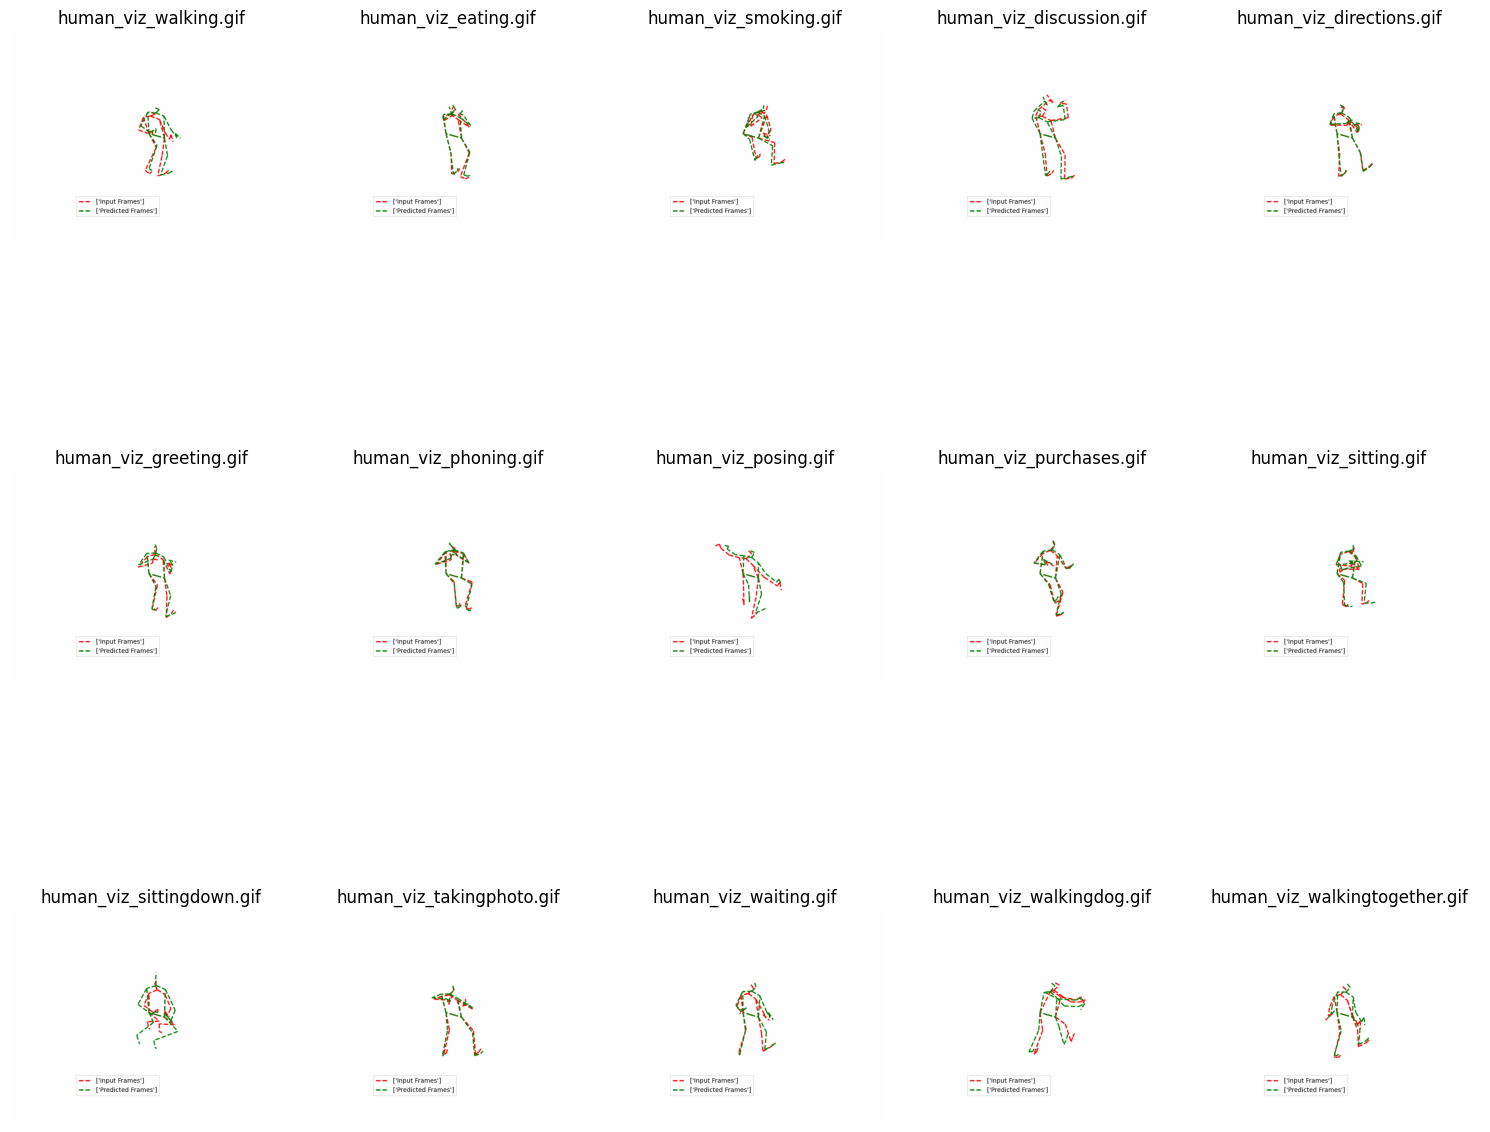

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Assuming all GIFs are in the same directory
gif_directory = '/content/drive/MyDrive/AML/Practice/GIFs'
gif_files = [f for f in os.listdir(gif_directory) if f.endswith('.gif')]

# Define the grid size
grid_size = (3, 5)  # 3 rows, 5 columns for 15 GIFs

fig, axes = plt.subplots(*grid_size, figsize=(15, 15))

# Load and display each GIF
for ax, gif_file in zip(axes.flatten(), gif_files):
    gif_path = os.path.join(gif_directory, gif_file)
    img = Image.open(gif_path)
    ax.imshow(img)
    ax.axis('off')  # Turn off axis
    ax.set_title(gif_file)

plt.tight_layout()
plt.show()


## Report and Parameter Fine-Tuning Analysis  (**4 Points**)

**Objective:** In this exercise, you will analyze the results obtained from a deep learning model you previously trained and perform parameter fine-tuning to optimize its performance. The key considerations are learning rate, milestones, and weight decay. **You will also use tables and plots to visualize and interpret the outcomes.**

**Instructions:**

1. **Analysis:** Analyze the generated report and answer the following questions:
   - Is there evidence of overfitting or underfitting in the initial training results?
   - Are there fluctuations in training and validation loss or accuracy? If so, what might be causing them?
   - What can you infer from the initial learning rate, milestones, and weight decay settings?

2. **Parameter Fine-Tuning:** Based on your analysis, perform parameter fine-tuning to optimize model performance. Adjust the following parameters:
   - **Learning Rate:** Experiment with different learning rates (higher and lower values) to find an optimal rate.
   - **Milestones:** Modify the milestone values for adjusting the learning rate schedule.
   - **Weight Decay:** Explore different weight decay values.
   

3. **Re-Training:** Train the model with the adjusted hyperparameters. Record the training progress and generate a new report, including performance metrics and line plots as before.

4. **Final Analysis:** Analyze the results of the fine-tuned model and compare them with the initial training. Answer the following questions:
   - Has parameter fine-tuning improved model performance?
   - Did it mitigate overfitting or underfitting issues?
   - What can you conclude about the optimal hyperparameters for this task?


In order to keep the Notebook clean, we decided to write hyperparameter fine-tuning report on the **PDF named "STTFormer fine-tuning report"**, placed in the "reports" folder.

We will copy here the explicit answers to provided questions.

### Analysis ###

**“*Is there evidence of overfitting or underfitting in the initial training results?*”**

Both training and validation losses are generally going down, so no overfitting nor underfitting is happening.
What we mean with "generally" is that, overall, we have a constant downtrend for both curves.


**“*Are there fluctuations in training and validation loss or accuracy? If so, what might be causing them?*”**

In some specific epochs, we do observe some spikes in the validation loss, which may be due to validation being performed on smaller amounts of data and/or a too fast learning rate.
The latter may make the model reach a local minimum, which corresponds to learning noise in the data as well.


**“*What can you infer from the initial learning rate, milestones, and weight decay settings?*”**

  - At the end of the fixed epoch budget, learning rate, milestone epochs (i.e. learning rate scheduler) and weight decay are performing their job, because both losses eventually decrease to some level of convergence.
  - Weight decay performed at milestone epochs 10 and 30 help train and validation losses get out of plateauing situations
  - Nevertheless, train and validation losses have “ideal shapes” across all epochs
  - If one wants to be picky, validation loss could have a better-looking “elbow-like shape”, in epochs < 10. This may probably depend on too small weight decay.
  - Overall, we think that default hyperparameters are fine as they are, because they do not yield to general over or underfit, since we have a constant downtrend for both curves.


### Final Analysis ###

**“*Has parameter fine-tuning improved model performance?*”**

Yes, parameter fine-tuning slightly improved performances, across all three losses.
Unfortunately, such improvements came in three different models, so there is no unique run with absolutely lowest losses across the board.
Considering the huge amount of extra trainable parameters that the better models have (1.2M vs. 23k), we do not consider the improvement worth it.


**“*Did it mitigate overfitting or underfitting issues?*”**

Original hyperparameters had a very “localized” overfit in some epochs and not an overall overfit trend (where val loss continuously grows, while train loss stays flat or decreases).
The only overall overfit case (where validation loss continuously grew, while train loss stayed down) we witnessed happened on a configuration of ours and, in that run, yes, hyperparameter tuning did solve the issue.


**“*What can you conclude about the optimal hyperparameters for this task?*”**

Original hyperparameter configuration was already very good.
Model positively, although negligibly, reacts to different milestone epochs, learning rate decay strength, number of attention heads and output convolutional channels.
In our tests, original weight decay proved to be the best, probably due to having been tested with other regularizations already in place.

All hyperparameters responded the way we hypothesized, e.g. higher loss if too much weight decay is applied, or faster initial loss, then noise if too strong learning was used, without decay.


## Calculating MPJPE for a Specific Frame  (**2 Points**)


In this exercise, you will calculate the Mean Per Joint Position Error (MPJPE) for a specific frame. This skill is valuable for assessing the accuracy of your model's predictions at a particular moment.

\begin{align*}
\text{MPJPE}_t = \frac{1}{N} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|
\end{align*}

Fixed the frame $t$, you will calculate the MPJPE for the predicted pose and the ground truth. Steps:

- Write a function that takes in input the predicted pose and the ground truth one and returns the MPJPE for a number of frames $t$. (e.g. the output could be a dictionary with the frame number as key and the MPJPE as value)
- Rewrite the test function to use the function you just wrote.
- Run the newly created test function for $t=[5, 10, 15, 25]$ and report the results in a table and plot.





In [38]:
def mpjpe_per_frame(sequences_predict,sequences_gt, frames_to_consider):
    '''
    Insert your code below
    '''

    #create the dictionary
    results = {}

    #select only the frames to consider
    for frame in frames_to_consider:

      #(8,25,96)
      #select the predicted frame and the grounf truth frame
      pred_frame = sequences_predict[:,frame-1]
      gt_frame = sequences_gt[:,frame-1]

      sequences_predict[:,frame-1]

      #calculate the error with the utils function
      error = mpjpe_error(pred_frame, gt_frame).item()

      #save in a dictionary
      results[frame] = error
    return results

In [39]:
def test_per_frame(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0


    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    ##################
    #added by us
    action_mpjpe_dict = {}

    ##################
    for action in actions:


      ############################
      #added by us
      total_loss_per_frame = {5: 0, 10: 0, 15: 0, 25: 0}
      total_sequences = 0

      ############################

      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          '''
          Insert your code below.
          The function mpjpe_per_frame should return the loss for each frame in the sequence. (e.g. a dictionary with keys the frames and values the loss for each frame)
          Keep a tab of the running loss for each frame and the number of frames in the sequence.
          '''
          frames_to_consider = [5, 10, 15, 25]

          # Get the mpjpe error
          dict_loss = mpjpe_per_frame(all_joints_seq, sequences_gt, frames_to_consider)

          # Sum the value with respect to the frame
          for frame, loss in dict_loss.items():
                total_loss_per_frame[frame] += loss

          total_sequences += 1

      '''
      Insert your code below.
      Average the loss over all the frames in the sequence and print the results.
      '''
      # Now we need to do the average
      avg_loss_per_frame = {frame: round(loss / total_sequences,4) for frame, loss in total_loss_per_frame.items()}

      # Print the result for every action
      # Delete if you want to print the avg loss per frame for every single action
      # Print(str(action),': ', str(avg_loss_per_frame))

      # update the dictionary
      action_mpjpe_dict[f"{action}"] = avg_loss_per_frame

    # Convert the dictionary data to a numpy array
    # First, we extract the values for each frame and store them in a list.
    frame_values = [[activity[frame] for activity in action_mpjpe_dict.values()] for frame in [5, 10, 15, 25]]

    # Convert the list of lists into a numpy array.
    frame_array = np.array(frame_values)

    # Calculate the sum and mean along the columns (axis=1)
    sums_np = np.sum(frame_array, axis=1)
    means_np = np.around(np.mean(frame_array, axis=1),4)

    # Convert the results back to dictionary format for better readability
    frame_indices = [5, 10, 15, 25]
    sums_dict = dict(zip(frame_indices, sums_np))
    means_dict = dict(zip(frame_indices, means_np))

    print("Means per frame: ", means_dict)

    # Return the dictionary (not asked but it might be usefull later on)
    return action_mpjpe_dict


In [40]:
'''
Insert your code below where you want to load the model and test it.
You need to specify the path to the model checkpoint file and call the test function.
'''
ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_40.pt'
dic_error_per_frame = test_per_frame(ckpt_path)

model loaded
walking :  {5: 43.0763, 10: 58.8609, 15: 65.6578, 25: 80.6874}
eating :  {5: 34.4805, 10: 51.7605, 15: 65.808, 25: 87.1019}
smoking :  {5: 38.4567, 10: 54.2872, 15: 65.8318, 25: 80.4713}
discussion :  {5: 49.8044, 10: 79.6903, 15: 102.1649, 25: 123.4331}
directions :  {5: 44.41, 10: 72.8869, 15: 90.4279, 25: 112.5546}
greeting :  {5: 59.6262, 10: 95.1018, 15: 117.9855, 25: 144.6979}
phoning :  {5: 42.9105, 10: 64.9896, 15: 84.4763, 25: 112.996}
posing :  {5: 60.1573, 10: 99.6572, 15: 133.1617, 25: 180.0607}
purchases :  {5: 61.2753, 10: 95.6491, 15: 119.2816, 25: 145.7073}
sitting :  {5: 49.7221, 10: 75.3798, 15: 97.6888, 25: 123.9002}
sittingdown :  {5: 66.8736, 10: 93.7337, 15: 118.8946, 25: 151.5423}
takingphoto :  {5: 48.5803, 10: 74.0419, 15: 96.9313, 25: 127.1364}
waiting :  {5: 47.4496, 10: 74.3879, 15: 93.9761, 25: 116.6874}
walkingdog :  {5: 72.8531, 10: 104.4652, 15: 124.5217, 25: 154.8257}
walkingtogether :  {5: 38.3177, 10: 56.5457, 15: 66.8922, 25: 76.5603}
Me

### Table and plot

In [41]:
# @title
# Convert the dictionary to a pandas DataFrame
error_per_frame = pd.DataFrame(dic_error_per_frame)
error_per_frame = error_per_frame.round(4).T
error_per_frame


,5,10,15,25
walking,43.0763,58.8609,65.6578,80.6874
eating,34.4805,51.7605,65.8080,87.1019
smoking,38.4567,54.2872,65.8318,80.4713
discussion,49.8044,79.6903,102.1649,123.4331
directions,44.4100,72.8869,90.4279,112.5546
greeting,59.6262,95.1018,117.9855,144.6979
phoning,42.9105,64.9896,84.4763,112.9960
posing,60.1573,99.6572,133.1617,180.0607
purchases,61.2753,95.6491,119.2816,145.7073
sitting,49.7221,75.3798,97.6888,123.9002


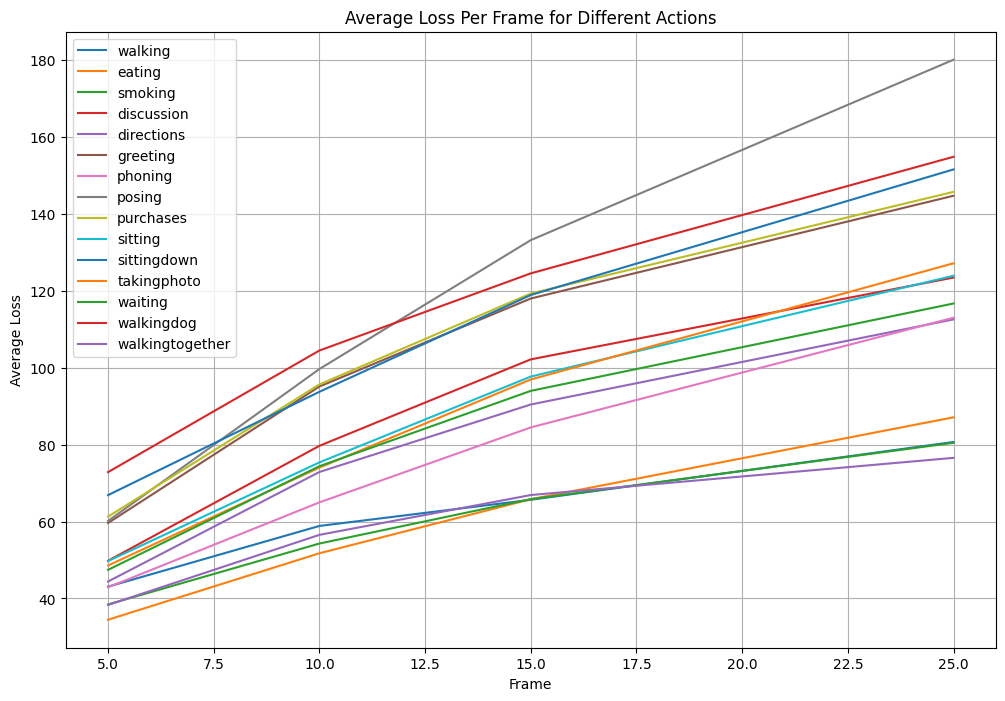

In [42]:
# @title
# Plotting the line plot for each row
plt.figure(figsize=(12, 8))
for action in error_per_frame.index:
    plt.plot(error_per_frame.columns, error_per_frame.loc[action], label=action)

plt.title('Average Loss Per Frame for Different Actions')
plt.xlabel('Frame')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

## Iterative Mechanism (**3 Points**)

In this exercise, you will explore the concept of an iterative mechanism and its adaptability when the model's output length changes. You will start with a model designed to produce 25 output frames but adapt it to generate only 10. The exercise will involve modifying and re-training the model for the new output length. During test time, the model will generate 10 frames and then use them as input to generate the successive 10 frames, and so on, until the desired number of frames is reached. In this case, you are asked to generate 25 frames.

The steps are as follows:
- Change the model's output length from 25 to 10.
- Re-train the model.
- Rewrite the test function to generate 25 frames using the iterative mechanism.
- Generate a new report and compare the results to the baseline model.

In [43]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name

#this was changed to the path of the dataset
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)

'''
Insert your code below
'''
output_n= 10 # number of frames to predict on

input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22

#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path_iterative= './checkpoints_iterative/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2


In [44]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n, output_n,skip_rate, split=0)

#dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,25,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


/content/drive/MyDrive/AML/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


In [45]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 182327
>>> Validation dataset length: 28110


In [46]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26694


In [47]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

### Train and Validation Loop

In [ ]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

[Epoch: 1, Iteration:     1]  training loss: 561.468
[Epoch: 1, Iteration:   201]  training loss: 100.764
[Epoch: 1, Iteration:   401]  training loss: 81.175
[Epoch: 1, Iteration:   601]  training loss: 79.338
[Epoch: 1, Iteration:     1]  validation loss: 70.752
[Epoch: 2, Iteration:     1]  training loss: 71.223
[Epoch: 2, Iteration:   201]  training loss: 71.027
[Epoch: 2, Iteration:   401]  training loss: 67.543
[Epoch: 2, Iteration:   601]  training loss: 67.209
[Epoch: 2, Iteration:     1]  validation loss: 69.046
[Epoch: 3, Iteration:     1]  training loss: 68.254
[Epoch: 3, Iteration:   201]  training loss: 65.446
[Epoch: 3, Iteration:   401]  training loss: 64.769
[Epoch: 3, Iteration:   601]  training loss: 62.314
[Epoch: 3, Iteration:     1]  validation loss: 73.221
[Epoch: 4, Iteration:     1]  training loss: 62.883
[Epoch: 4, Iteration:   201]  training loss: 60.926
[Epoch: 4, Iteration:   401]  training loss: 58.821
[Epoch: 4, Iteration:   601]  training loss: 58.597
[Epo

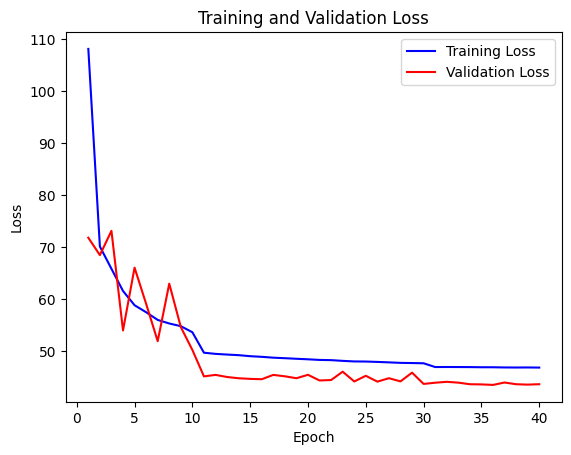

In [ ]:
# launch training with the new output_n
train(data_loader,vald_loader, path_to_save_model=model_path_iterative)

### Test Loop

In [59]:
def test_iterative(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

    ############################

    action_mpjpe_dict = {}

    ############################
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      ############################
      #aggiunto da noi
      total_loss_per_frame = {5: 0, 10: 0, 15: 0, 25: 0}
      total_sequences = 0

      ############################
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,25,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+25, :]

          running_time = time.time()

          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          '''
          Insert your code below. You will need to iteratively predict the next frames and feed it to back to the model until you reach the desired number of frames.
          '''

          # NB: the dimension of the input of the model is (8,3,10,22)
          # so we need to permute the newly obtained output, to be inserted in the input
          sp_permuted = sequences_predict.permute(0, 3, 1, 2)

          # Use this new input sequence (sp_permuted) to predict the next 10 frames.
          sequences_next_predict = model(sp_permuted).view(-1, output_n, joints_to_consider, 3)

          # concatenate the new output with the old one, we will have 20 predicted frames after this
          sequences_final_predict = torch.cat((sequences_predict, sequences_next_predict[:, :, :, :]), dim=1)

          # permute the new output to be inserted as the input (same as before)
          snp_permuted = sequences_next_predict.permute(0, 3, 1, 2)

          # Use this new input sequence to predict the next 10 frames.
          sequences_next_predict2 = model(snp_permuted).view(-1, output_n, joints_to_consider, 3)

          # concatenate the next 5
          sequences_final_predict = torch.cat((sequences_final_predict, sequences_next_predict2[:, :5, :, :]), dim=1)

          frames_to_consider = [5, 10, 15, 25]

          # Assign sequences_final_predict to the new tensor
          # Reshape sequences_final_predict to have a shape of [8, 25, 66]

          sequences_final_predict_reshaped = sequences_final_predict.view(batch_dim, 25, -1)
          all_joints_seq[:, :, dim_used] = sequences_final_predict_reshaped
          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          # get the mpjpe error
          dict_loss = mpjpe_per_frame(all_joints_seq, sequences_gt, frames_to_consider)

          # sum the value with respect to the frame
          for frame, loss in dict_loss.items():
                total_loss_per_frame[frame] += loss

          total_sequences += 1

      '''
      Insert your code below.
      Average the loss over all the frames in the sequence and print the results.
      '''

      # now we need to do the average
      avg_loss_per_frame = {frame: round(loss / total_sequences,4) for frame, loss in total_loss_per_frame.items()}

      # print the result for every action
      # delete if you want to print the avg loss per frame for every single action
      # print(str(action),': ', str(avg_loss_per_frame))

       #update the dictionary
      action_mpjpe_dict[f"{action}"] = avg_loss_per_frame

    # Convert the dictionary data to a numpy array
    # First, we extract the values for each frame and store them in a list.
    frame_values = [[activity[frame] for activity in action_mpjpe_dict.values()] for frame in [5, 10, 15, 25]]

    # Convert the list of lists into a numpy array.
    frame_array = np.array(frame_values)

    # Calculate the sum and mean along the columns (axis=1)
    sums_np = np.sum(frame_array, axis=1)
    means_np = np.around(np.mean(frame_array, axis=1),4)

    # Convert the results back to dictionary format for better readability
    frame_indices = [5, 10, 15, 25]
    sums_dict = dict(zip(frame_indices, sums_np))
    means_dict = dict(zip(frame_indices, means_np))

    print("Means per frame: ", means_dict)

    # return the dictionary (not asked but it might be usefull later on)
    return action_mpjpe_dict


In [60]:
model_path_iterative = './checkpoints_iterative/h36m_3d_10frames_ckpt_epoch_40.pt' # Change the epoch according to the validation curve
dic_error_per_frame_iterative =test_iterative(ckpt_path=model_path_iterative)

model loaded


/content/drive/MyDrive/AML/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Means per frame:  {5: 46.3489, 10: 75.0666, 15: 97.7037, 25: 125.3715}


In [57]:
# @title
# Convert the dictionary to a pandas DataFrame
error_per_frame_iterative = pd.DataFrame(dic_error_per_frame_iterative)
error_per_frame_iterative = error_per_frame_iterative.round(4).T
error_per_frame_iterative

,5,10,15,25
walking,38.1013,58.4739,72.7804,84.9222
eating,31.8543,51.7532,68.6009,90.7315
smoking,34.1918,51.0935,66.5382,85.6450
discussion,45.7698,78.8613,103.6012,126.0296
directions,40.1326,70.6781,89.0132,114.1979
greeting,57.2630,95.8053,120.3664,145.4705
phoning,38.8354,64.2118,87.3056,118.8212
posing,53.2978,95.8155,132.4965,181.9671
purchases,57.3140,91.8055,116.1647,145.6459
sitting,46.8617,72.9380,99.3249,132.8467


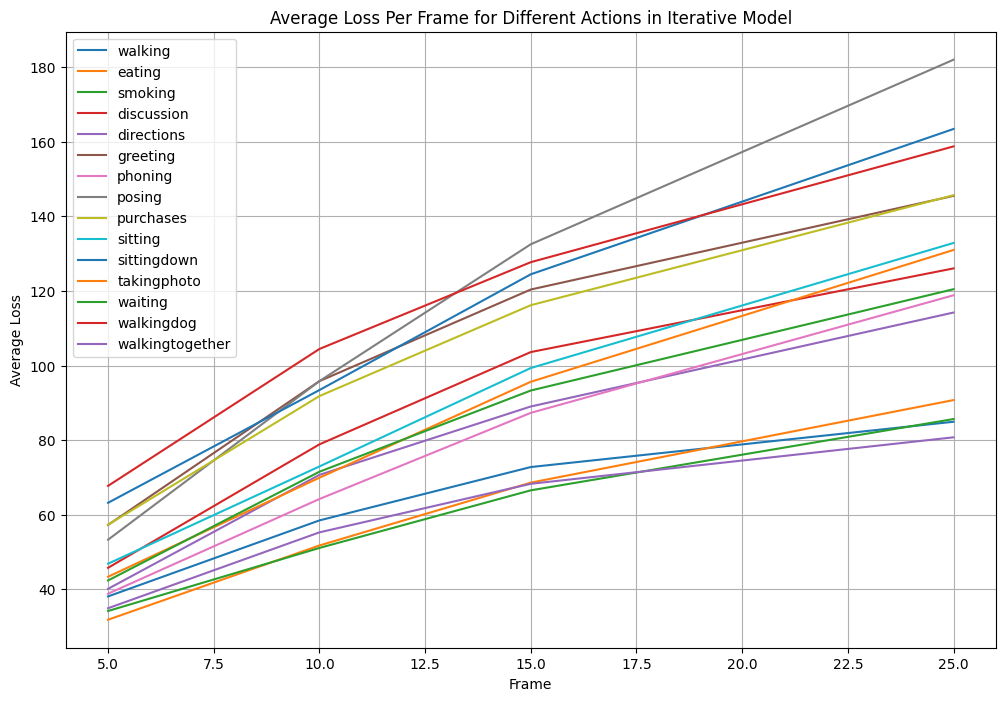

In [103]:
# @title
# Plotting the line plot for each row
plt.figure(figsize=(12, 8))


for action in error_per_frame_iterative.index:
    plt.plot(error_per_frame_iterative.columns, error_per_frame_iterative.loc[action], label=action)

plt.title('Average Loss Per Frame for Different Actions in Iterative Model')
plt.xlabel('Frame')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

## Comparison Baseline - Iterative

To compare the two results we will do a comparison with the MPJPE error obtained by both models, first with an average of the results, and then we will compare them by actions to look into more in depth information.

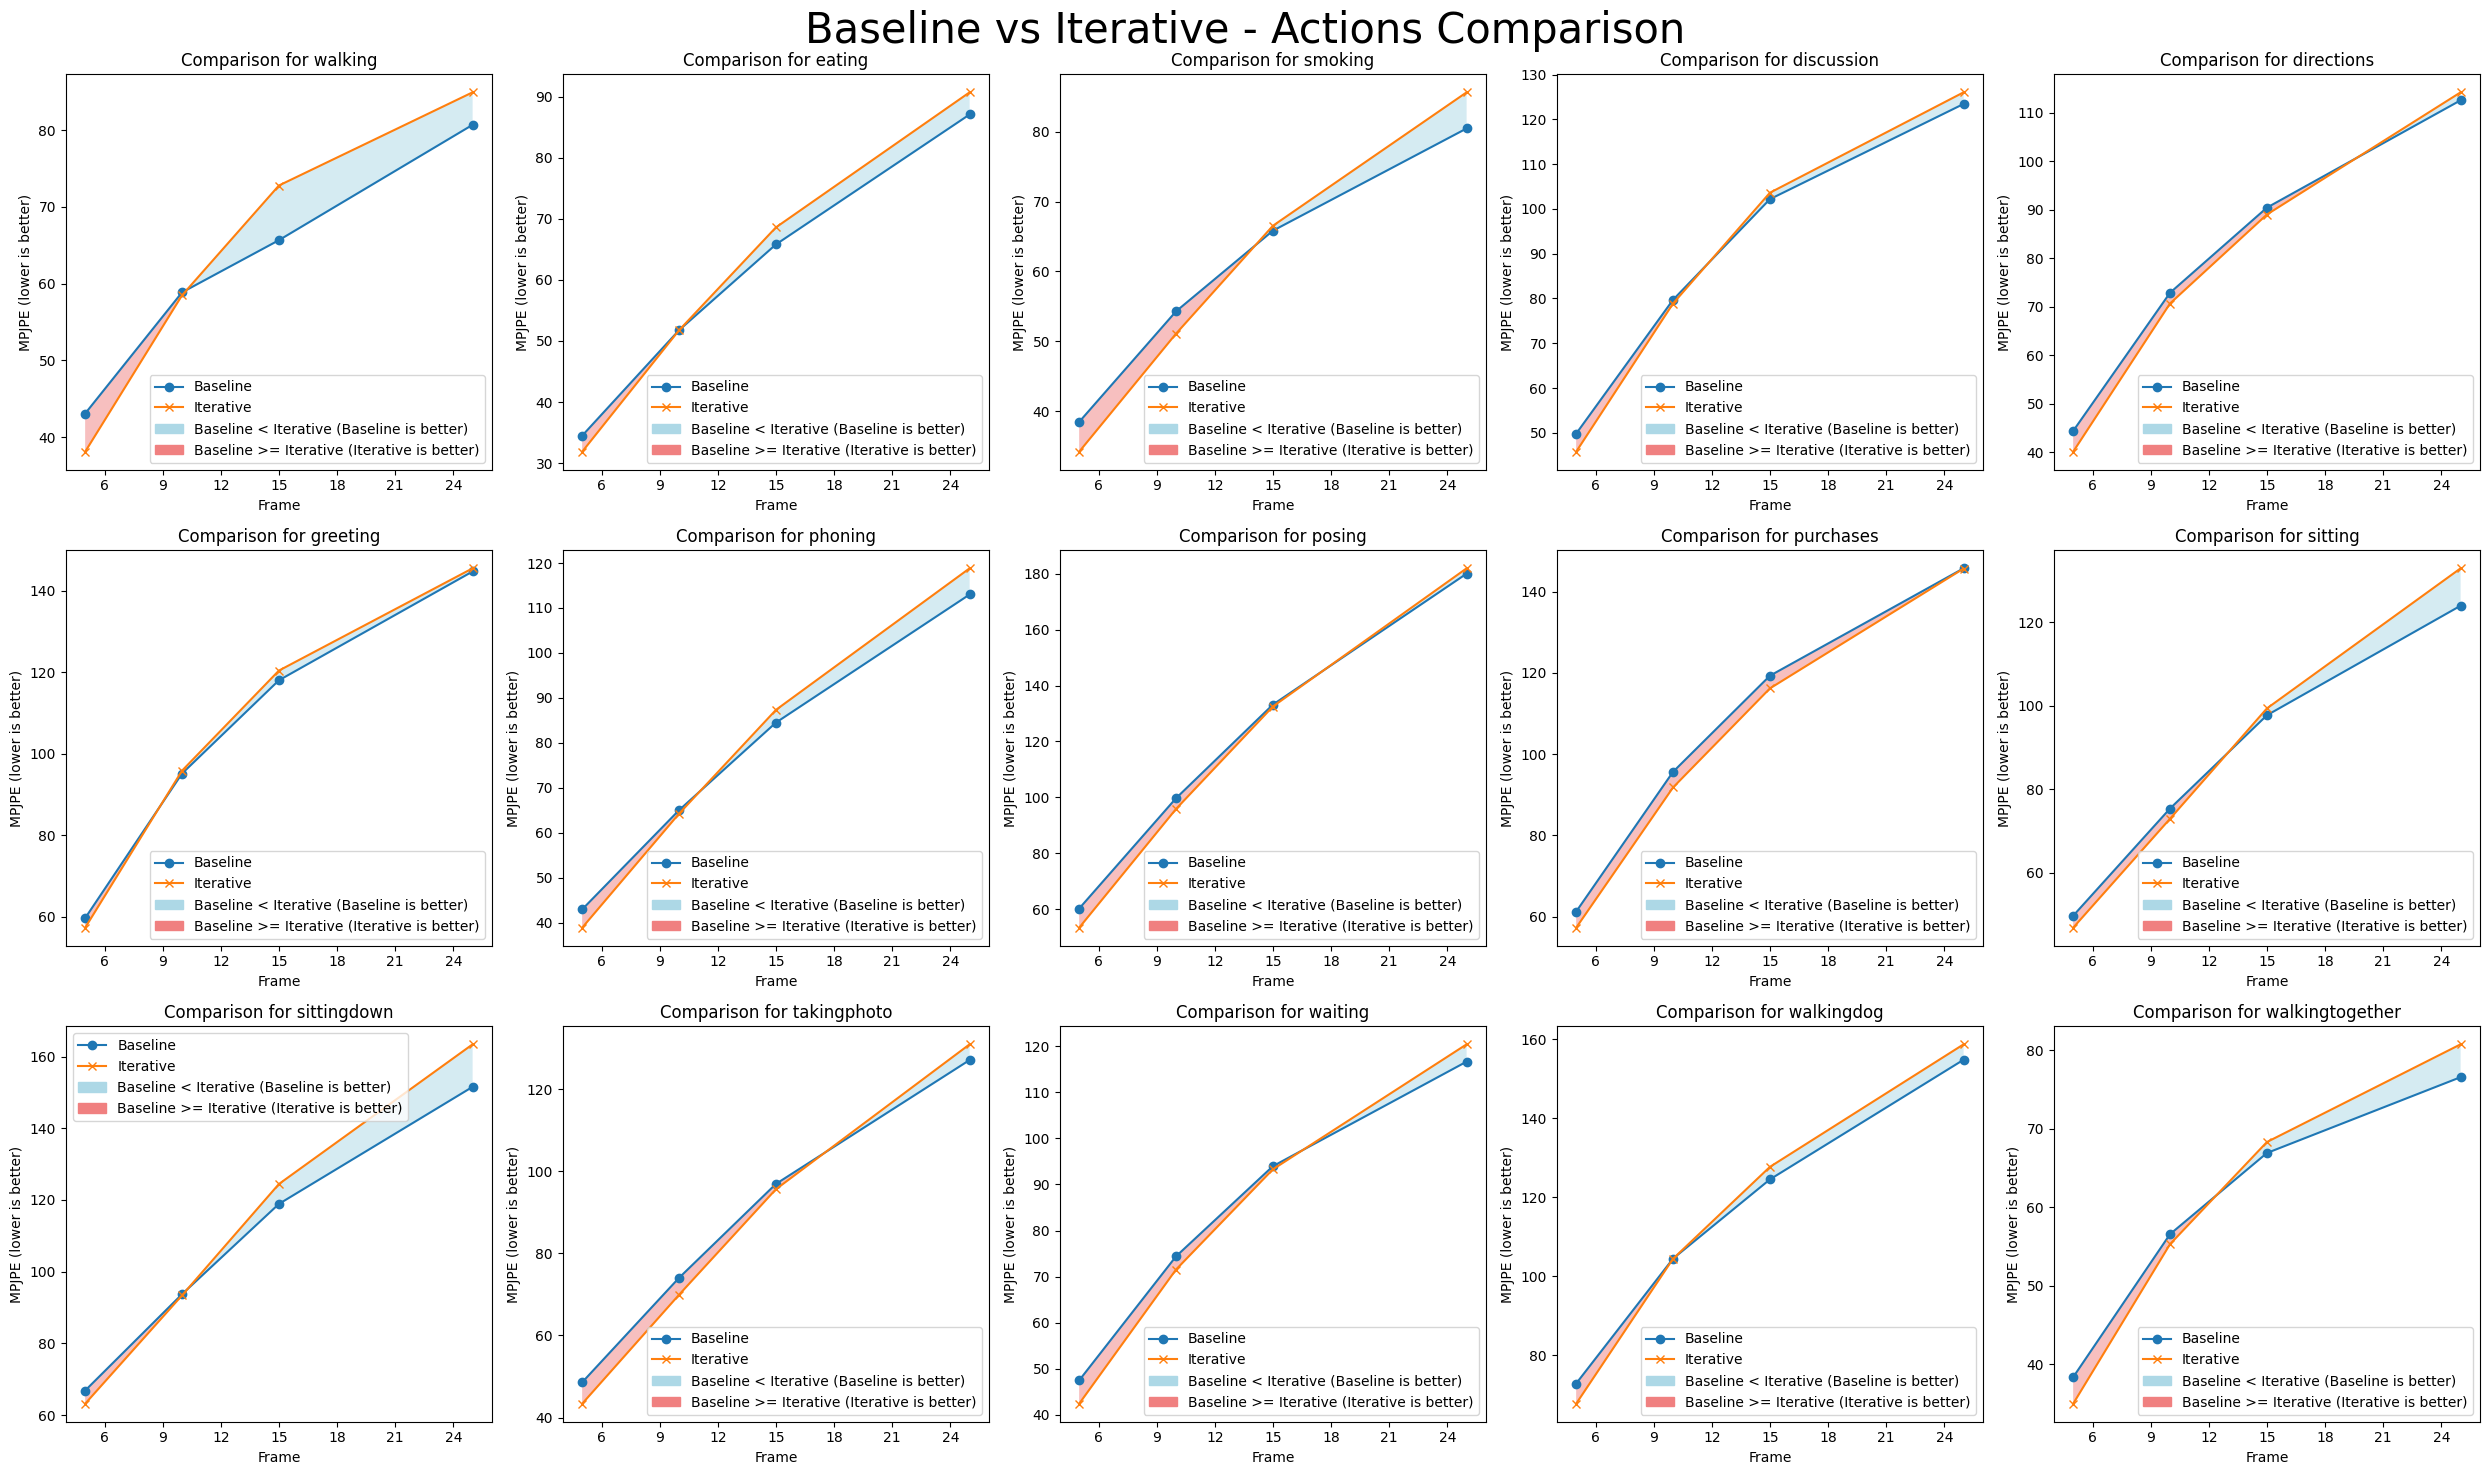

In [92]:
# @title
# Assuming num_activities is the number of different activities you have
num_activities = len(error_per_frame)

# Define a 3x5 grid for the subplots
fig, axes = plt.subplots(3, 5, figsize=(25, 15))  # Adjust the figsize as needed

# Set title
fig.suptitle('Baseline vs Iterative - Actions Comparison', fontsize=30)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Create custom patches for the legend
red_patch= Patch(color='lightcoral', label='Baseline >= Iterative (Iterative is better)')
blue_patch = Patch(color='lightblue', label='Baseline < Iterative (Baseline is better)')

for i, (row1, row2) in enumerate(zip(error_per_frame.iterrows(), error_per_frame_iterative.iterrows())):

    activity, values1 = row1[1].name, row1[1].values
    _, values2 = row2[1].name, row2[1].values

    # Ensure that the scales are integers for plotting
    scales = np.array([5, 10, 15, 25], dtype=int)

    # Convert values to numpy arrays for comparison
    values1 = np.array(values1, dtype=float)
    values2 = np.array(values2, dtype=float)

    # Plot the lines for both datasets
    line1, = axes[i].plot(scales, values1, label=f'Baseline', marker='o')
    line2, = axes[i].plot(scales, values2, label=f'Iterative', marker='x')

    # Fill area between the lines
    axes[i].fill_between(scales, values1, values2, where=(values1 >= values2),
                         facecolor='lightcoral', alpha=0.5, interpolate=True)
    axes[i].fill_between(scales, values1, values2, where=(values1 < values2),
                         facecolor='lightblue', alpha=0.5, interpolate=True)

    # Adding titles and labels
    axes[i].set_title(f'Comparison for {activity}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('MPJPE (lower is better)')

    # Set x-axis to show only integer values
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Adding legend with custom patches for filled areas
    axes[i].legend(handles=[line1, line2, blue_patch, red_patch])

# Hide any unused axes
for j in range(num_activities, 15):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Baseline VS Iterative Performance

As we can see from the results obtained above in some activities, such as 'walking', 'eating', 'smoking', 'phoning', 'posing', 'waiting', and 'walkingtogether', the 'Iterative' method consistently outperforms the 'Baseline' for the first 5 to 10 number of frames, this is evident by the 'Iterative' line being below the 'Baseline' for most frame numbers.

But the situation starts to change for the frames going from 11 to 25, indeed as we can see from our results the 'Iterative' approach seems to lead to an higher MPJPE error as the number of frames increases.

This might be possible for a number of reason. The first one is that the Iterative model was trained for an initial output of only 10 frames, while the Baseline model was trained for 25 frames, more than double. This approach is the reason why the 'Iterative' model usually outperform the 'Baseline' for the early frames.

The situation is different for the last predicted frames, in fact the 'Iterative' model almost never keep up with the 'Baseline' and the trend seems to suggest that as the number of frames increases the gap between the two models will only get bigger. This might be due to the problem known as 'Error Propagation (or Accumulation)' where the Iterative methods may accumulate small errors over time that compound, leading to larger errors in later frames.

### Performance for single actions
If we take this analysis from the single types of action perspective, we find that certain actions performs way better than others, this might be due to the complexity of the action itselft.

We can see that for the more complex actions, there is no wide gap between the two models, and this might be because both models fail to extract a good enough rappresentations of the actions.

### Conclusion
Overall we can say that if we have a lower number of frames the 'Iterative' approach might be better to predict the frames, but if we have longer sequences then the Baseline approach outperforms the 'Iterative' in almost every actions. If we don't have the possibiliy of applying the 'Baseline' approach then we must be carefull to finetune the 'Iterative' model to obtain a lower error in the early frames, as the error might compound over time.

## YOUR custom model (**3 Points**)
 In this exercise, you will implement a Transformer-like network (based on the Theory notebook) for this specific task. You can use the Transformer's Encoder and implement your own Decoder to predict future poses. (e.g. RNN, MLP, CNN, TCN, ...).
 We won't provide any code for this exercise, but you can use the code provided in the Theory notebook as a starting point.
 The goal of this exercise is not to beat the previous model but to understand how to implement a Transformer network for this specific task. For this reason, the evaluation will be based on the code you write and the explanation you provide in the report rather than the results.


### Performance BONUS (**Up to 2 Points**)
- **1 Bonus Point** if the model achieves an A-MPJPE between 80 and 90 millimeters.
- **2 Bonus Points** if the model achieves an A-MPJPE between 70 and 80 millimeters.


**Full report in "Custom model - final report.pdf" file in the reports folder.**

For practicality, we copy its conclusions here.

### Full report conclusions ###

We experimented with four different setups, namely *ConvSTGAT*, *STACFormer*, *STCFormer* and *STCFormer-autoregressive*, and achieved train, validation and test **A-MPJPE losses < 80 mm** in STCFormer.<br><br>
STCFormer is a spatio-temporal Transformer whose Encoder and Decoder use the spatio-temporal “CrissCross” attention described in the <a href="https://openaccess.thecvf.com/content/CVPR2023/papers/Tang_3D_Human_Pose_Estimation_With_Spatio-Temporal_Criss-Cross_Attention_CVPR_2023_paper.pdf">STCFormer paper</a>, while STCFormer-autoregression is STCFormer with validation and test performed in an autoregressive way.
We adapted our autoregression implementation and loss from <a href="https://arxiv.org/abs/2203.11878">this paper</a>.<br><br>
STCFormer achieves 83.33, 71.88 and 77.7 mm of train, validation and test A-MPJPE loss, while STFFormer-autoregressive reaches 112, 105 and 110 train, validation and test losses.


We gave a look at the spatial and temporal attentions learnt by STCFormer, which made us discover some level of similarity between spatial and temporal patterns discovered by model itself.


All the experiments allowed us to practice literature research, adapting open-source code to our own needs, hyperparameter fine-tuning, hypothesis formulation and testing.

For all details, please refer to the **full report in "Custom model - final report.pdf" file in the reports folder.**

### Code ###

Each experiment has its own code in the models folder and its main script in the Practice root folder.
In order to keep main scripts clean, we exported all hyperparameters as constant in a separate .py file.
This is the complete list of files:
- *ConvSTGAT*:
  - models          $\to$ ./Practice/models/ConvSTGAT
  - main script     $\to$ ./Practice/ConvSTGAT.py
  - hyperparameters $\to$ ./Practice/ConvSTGAT_config.py<br><br>
- *STACFormer*:
  - models          $\to$ ./Practice/models/STCAGFormer
  - main script     $\to$ ./Practice/STCAGFormer.py
  - hyperparameters $\to$ ./Practice/STCAGFormer_config.py<br><br>
- *STCFormer*:
  - models          $\to$ ./Practice/models/STCFormer
  - main script     $\to$ ./Practice/STCFormer.py
  - hyperparameters $\to$ ./Practice/STCFormer_config.py<br><br>
- *STCFormer-autoregressive*:
  - models          $\to$ ./Practice/models/STCFormer
  - main script     $\to$ ./Practice/STCFormer_autoreg.py
  - hyperparameters $\to$ ./Practice/STCFormer_autoreg_config.py<br><br>

For all details, please refer to the **full report in "Custom model - final report.pdf" file in the reports folder.**

As an example, we will import just one of the four models that we produced, *STCFormer*, because it achieves train, validation and test **A-MPJPE losses < 80 mm** (<a href=https://wandb.ai/dansolombrino/Custom-model-SpatioTemporalTransformer/runs/sa0wl8oh>Weights and Biases run</a>)

For all details, please refer to the **full report in "Custom model - final report.pdf" file in the reports folder.**

In [ ]:
from STCFormer import main as STCFormer_run

# change this to True to perform training with the default hyperparameters
# Hyperparams can be changed on STCFormer_config.py
STCFORMER_PERFORM_TRAIN = False

if STCFORMER_PERFORM_TRAIN:
  STCFormer_run()

<img src="./assets/faithful-glade-43-losses.png"></img>

For all details, please refer to the **full report in "Custom model - final report.pdf" file in the reports folder.**

Checkpoints can be found <a href=https://drive.google.com/drive/folders/1HQ8J1Egj4KkqGnbppqTcqaFDvhZyiQ91>here</a>